In [1]:
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
import warnings
import time
import seaborn
from torch import nn
from typing import Optional,Union
from torchvision import transforms

### 在之前建模过的网络上应用残差块
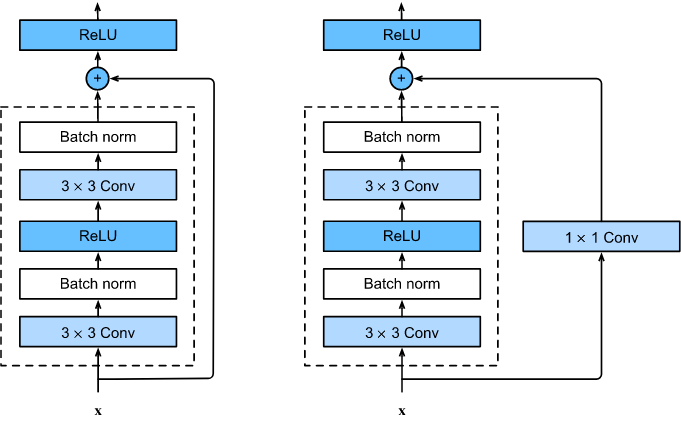

In [26]:
class Residual(nn.Module):
    def __init__(self, out_channels:int, use_1x1conv=False, stride=1) -> None:
        super().__init__()
        self.b1 = nn.Sequential(
            nn.LazyConv2d(out_channels,kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.LazyConv2d(out_channels, kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels)
        )
        # 使用1x1主要是将X的特征与G(x)的特征维度转换到相同,reshape会损失信息且会改变图片形状故需要1x1卷积核
        if use_1x1conv:
            self.b2 = nn.LazyConv2d(out_channels,kernel_size=1,stride=stride)
        else:
            self.b2 = None
    
    def forward(self, X:torch.Tensor)->torch.Tensor:
        g_x = self.b1(X)
        if self.b2:
            X = self.b2(X)
        return nn.functional.relu(g_x + X)

model = Residual(8,use_1x1conv=True)
model(torch.rand(3,3,28,28)).shape

e:\ProgramData\Anaconda3\envs\pytorchenv\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([3, 8, 28, 28])

#### 搭建何凯明的ResNet18
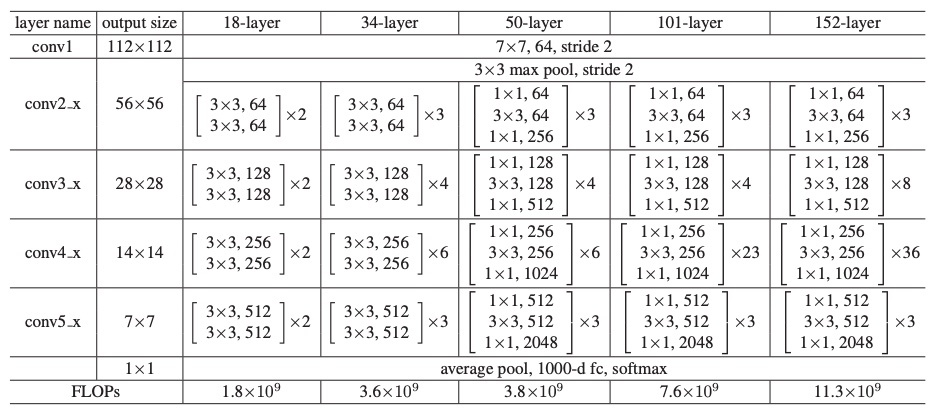

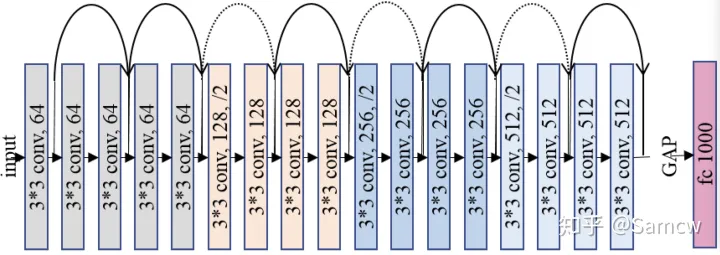

In [44]:
# 上图带箭头的为残差块,以两个残差块为一个大block构建
class ResNetBlock(nn.Module):
    def __init__(self, arch:Optional[list], n_classes:int, stride=2) -> None:
        super().__init__()
        self.net = nn.Sequential()
        self.net.add_module('0', nn.Sequential(
            nn.LazyConv2d(out_channels=64, kernel_size=7, stride=stride, padding=3),
            nn.LazyBatchNorm2d(),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=stride)
        ))
        
        for i,b in enumerate(arch):
            self.net.add_module(f"b{i}", self.resblock(*b, first_block=(i==0)))
        # 加上最后的全局平均池化 全连接层
        self.net.add_module("gap",nn.AdaptiveAvgPool2d((1,1)))
        self.net.add_module("flatten",nn.Flatten())
        self.net.add_module("fc", nn.LazyLinear(n_classes))

    def resblock(self, n_layers:int, out_channels:int, first_block)->None:
        blk=[]
        for i in range(n_layers):
            # 每过1个block channel*2, height,width/2->stride=2
            # 只有第一个大块不需要用1x1卷积核来改变输入的大小适配g_x的输出, 输出的通道数、h,w都保持不变->stride=1
            # 剩余的大块中又只有第一个小块才需要使用1x1conv
            if i==0 and not first_block:
                blk.append(Residual(out_channels,use_1x1conv=True,stride=2))
            else:
                blk.append(Residual(out_channels))
        return nn.Sequential(*blk)

    def forward(self,X):
        return self.net(X)

class ResNet18(ResNetBlock):
    def __init__(self, n_classes:int) -> None:
        super().__init__(((2,64),(2,128),(2,256),(2,512)),n_classes)
model = ResNet18(10)# 期望结果(1,10)
model(torch.rand(1,1,96,96)).shape

e:\ProgramData\Anaconda3\envs\pytorchenv\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([1, 10])

In [45]:
# 查看模型结构
model

ResNet18(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (b0): Sequential(
      (0): Residual(
        (b1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Residual(
        (b1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [39]:
# 忘记拉直层的结果
# 提取模型中单层来看
with torch.no_grad():
    print(model.net[-2](torch.rand(1,512,3,3)).shape)
model.net[-1].weight.shape

torch.Size([1, 512, 1, 1])


torch.Size([10, 1])

In [38]:
(torch.rand(1,512,1,1)@torch.rand(1,10)).shape

torch.Size([1, 512, 1, 10])

#### ResNext
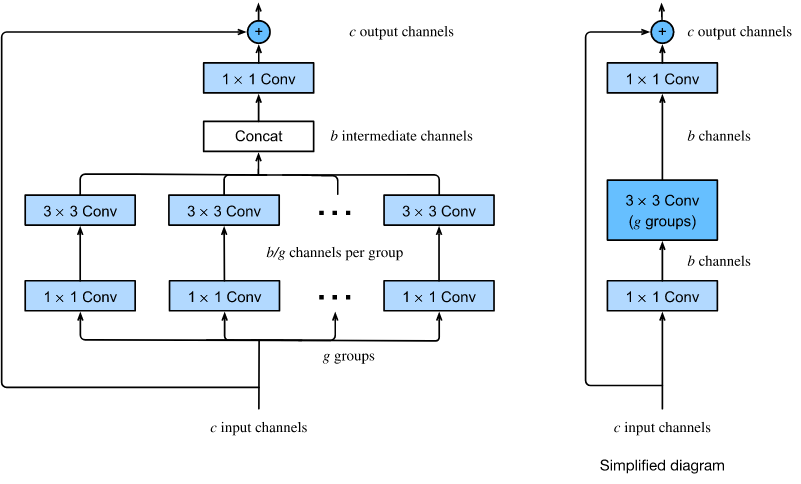

In [2]:
class ResNeXtBlock(nn.Module):
    """The ResNeXt block."""
    def __init__(self, out_channels, groups, bot_mul, use_1x1conv=False,
                    strides=1):
        # using (use_1x1conv=False, strides=1), the input and output are of the same shape. 
        # Alternatively, setting use_1x1conv=True, strides=2 halves the output height and width.
        super().__init__()
        # group channels
        bot_channels = round(out_channels * bot_mul)
        self.b1 = nn.Sequential(
            nn.LazyConv2d(bot_channels, kernel_size=1, stride=1),
            nn.LazyBatchNorm2d(),nn.ReLU(),
            nn.LazyConv2d(bot_channels, kernel_size=3,
                        stride=strides, padding=1,
                        groups=bot_channels//groups),
            nn.LazyBatchNorm2d(),nn.ReLU(),
            nn.LazyConv2d(out_channels, kernel_size=1, stride=1),
            nn.LazyBatchNorm2d(),nn.ReLU()
            )
        
        if use_1x1conv:
            self.b2 = nn.Sequential(nn.LazyConv2d(out_channels, kernel_size=1,stride=strides),
                                    nn.LazyBatchNorm2d()    
                        )
        else:
            self.b2 = None

    def forward(self, X):
        Y = self.b1(X)
        if self.b2:
            X = self.b2(X)
        return nn.functional.relu(Y + X)
model = ResNeXtBlock(out_channels=32, groups=16,bot_mul=1)
model(torch.rand(4,32,96,96)).shape# stride=1 =>keep the same as origin/stride=2 => 4,32,48,48

e:\ProgramData\Anaconda3\envs\pytorchenv\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 32, 96, 96])